# Effects Of Space Weather 
## MSDS 696 Practicum II 
#### Regis University 
#### Heather Holcomb 

#### Can i predict space weather using historical data? 

In [66]:
# Load necessary libraries 
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
import netCDF4
import seaborn as sns
import numpy as np 
import statsmodels.formula.api as smf
import statsmodels.api as sm
import fbprophet
import random
import pydot
import datetime
import itertools

from netCDF4 import Dataset
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Load/Clean Space Weather Data

In [2]:
dfSpaceWeather = pd.read_csv('Data\SpaceWeatherData_Cleaned', header = 0, delimiter=r"\s+")
dfSpaceWeather.columns

Index(['yy', 'mm', 'dd', 'BSRN', 'ND', 'Kp', 'Kp.1', 'Kp.2', 'Kp.3', 'Kp.4',
       'Kp.5', 'Kp.6', 'Kp.7', 'Sum', 'Ap', 'Ap.1', 'Ap.2', 'Ap.3', 'Ap.4',
       'Ap.5', 'Ap.6', 'Ap.7', 'Avg', 'Cp', 'C9', 'ISN', 'F10.7', 'Q', 'Ctr81',
       'Lst81', 'F10.7.1', 'Ctr81.1', 'Lst81.1'],
      dtype='object')

In [3]:
#Rename columns to make sense 
dfSpaceWeather = dfSpaceWeather.rename(columns={
    "yy": "Year", 
    "mm": "Month", 
    "dd": "Day", 
    "BSRN": "BartelsSolarRotationNumber", 
    "ND": "NumberofDaywithintheBartels", 
    "Kp": "Kp_0000_0300", 
    "Kp.1": "Kp_0300_0600", 
    "Kp.2": "Kp_0600_0900", 
    "Kp.3": "Kp_0900_1200", 
    "Kp.4": "Kp_1200_1500",
    "Kp.5": "Kp_1500_1800",
    "Kp.6": "Kp_1800_2100",
    "Kp.7": "Kp_2100_0000",
    "Sum": "SumOfKps", 
    "Ap": "PlanetaryEquivalentAmplitude_0000_0300",
    "Ap.1": "PlanetaryEquivalentAmplitude_0300_0600",
    "Ap.2": "PlanetaryEquivalentAmplitude_0600_0900",
    "Ap.3": "PlanetaryEquivalentAmplitude_0900_1200",
    "Ap.4": "PlanetaryEquivalentAmplitude_1200_1500",
    "Ap.5": "PlanetaryEquivalentAmplitude_1500_1800",
    "Ap.6": "PlanetaryEquivalentAmplitude_1800_2100",
    "Ap.7": "PlanetaryEquivalentAmplitude_2100_0000",
    "Avg": "ArithmeticAverageof8Ap",
    "Cp": "PlanetaryDailyCharacterFigure", 
    "C9": "CpConversion", 
    "ISN": "InternationalSunspotNumber",
    "F10.7": "F10_7",
    "Q": "FluxQualifier",
    "Ctr81": "Centered81_dayArithmeticAverageofF10_7",
    "Lst81": "Last81DayArithmeticAverageofF10_7", 
    "F10.7.1": "ObservedValueOfF10_7",
    "Ctr81.1": "Centered81DayArithmeticAverageOfF10_7",
    "Lst81.1": "Last81DayArithmeticAverageOfF10_7"})

In [4]:
spaceWeather_dict = dfSpaceWeather.groupby(['Year','Month']).agg({
    'SumOfKps': 'mean',
    'ArithmeticAverageof8Ap': 'mean',
    'PlanetaryDailyCharacterFigure': 'mean',
    'NumberofDaywithintheBartels' : 'mean',
    'PlanetaryDailyCharacterFigure' : 'mean',
    'CpConversion' : 'mean',
    'InternationalSunspotNumber' : 'mean',
    'F10_7' : 'mean',
    'FluxQualifier' : 'mean',
    'Centered81_dayArithmeticAverageofF10_7' : 'mean',
    'Last81DayArithmeticAverageofF10_7' : 'mean',
    'ObservedValueOfF10_7' : 'mean',
    'Centered81DayArithmeticAverageOfF10_7' : 'mean',
    'Last81DayArithmeticAverageOfF10_7' : 'mean'
})
spaceWeather_dict

SumOfKps  ArithmeticAverageof8Ap  PlanetaryDailyCharacterFigure  \
Year Month                                                                      
1957 10     198.612903               13.774194                       0.683871   
     11     223.766667               18.033333                       0.810000   
     12     232.483871               17.741935                       0.841935   
1958 1      208.387097               14.741935                       0.738710   
     2      265.642857               26.857143                       0.978571   
...                ...                     ...                            ...   
2019 11      79.333333                4.200000                       0.156667   
     12      67.419355                3.064516                       1.870968   
2020 1       98.709677                4.806452                       5.935484   
     2      126.206897                6.413793                       0.379310   
     3      107.636364                4.818182                      15.181818   

            NumberofDaywithintheBartels  CpConversion  \
Year Month                                              
1957 10                       14.838710      3.225806   
     11                       15.000000      3.700000   
     12                       14.000000      3.903226   
1958 1                        12.774194      3.354839   
     2                        13.750000      4.500000   
...                                 ...           ...   
2019 11                       14.200000      0.566667   
     12                       14.709677     70.967742   
2020 1                        15.225806     72.322581   
     2                        14.862069     71.034483   
     3                         6.000000     57.181818   

            InternationalSunspotNumber       F10_7  FluxQualifier  \
Year Month                                                          
1957 10                     253.806452  281.225806       0.000000   
     11                     210.866667  256.100000       0.000000   
     12                     239.419355  284.322581       0.129032   
1958 1                      202.451613  247.870968       0.000000   
     2                      164.928571  209.857143       0.142857   
...                                ...         ...            ...   
2019 11                       0.500000   68.663333       0.000000   
     12                       0.000000   70.593548      68.380645   
2020 1                        0.000000   71.490323      70.090323   
     2                        0.000000   71.275862      71.362069   
     3                       12.909091   71.163636      71.581818   

            Centered81_dayArithmeticAverageofF10_7  \
Year Month                                           
1957 10                                 269.212903   
     11                                 270.756667   
     12                                 268.045161   
1958 1                                  251.338710   
     2                                  233.932143   
...                                            ...   
2019 11                                  68.796667   
     12                                  73.248387   
2020 1                                   74.709677   
     2                                   72.800000   
     3                                   71.172727   

            Last81DayArithmeticAverageofF10_7  ObservedValueOfF10_7  \
Year Month                                                            
1957 10                            241.138710            283.109677   
     11                            266.740000            259.216667   
     12                            269.800000            289.358065   
1958 1                             271.277419            251.506452   
     2                             257.303571            211.796429   
...                                       ...                   ...   
2019 11                             68.026667    

In [5]:
dfSpaceWeatherAverage = pd.DataFrame(spaceWeather_dict)
df = pd.DataFrame(dfSpaceWeatherAverage)

In [6]:
dfSpaceWeather

,Year,Month,Day,BartelsSolarRotationNumber,NumberofDaywithintheBartels,Kp_0000_0300,Kp_0300_0600,Kp_0600_0900,Kp_0900_1200,Kp_1200_1500,...,PlanetaryDailyCharacterFigure,CpConversion,InternationalSunspotNumber,F10_7,FluxQualifier,Centered81_dayArithmeticAverageofF10_7,Last81DayArithmeticAverageofF10_7,ObservedValueOfF10_7,Centered81DayArithmeticAverageOfF10_7,Last81DayArithmeticAverageOfF10_7
0,1957,10,1,1700,19,43,40,30,20,37,...,1.1,5.0,236.0,268.0,0.0,265.2,230.6,269.3,266.6,230.9
1,1957,10,2,1700,20,37,37,17,17,27,...,0.7,3.0,234.0,252.0,0.0,266.0,231.4,253.3,267.4,231.7
2,1957,10,3,1700,21,27,20,13,33,37,...,1.0,5.0,242.0,265.0,0.0,266.7,232.3,266.3,268.1,232.7
3,1957,10,4,1700,22,30,30,23,27,23,...,0.7,3.0,217.0,237.0,0.0,267.4,232.9,238.2,268.8,233.3
4,1957,10,5,1700,23,30,30,17,23,20,...,0.6,3.0,219.0,245.0,0.0,267.8,233.5,246.2,269.3,233.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22803,2020,3,7,2545,7,10,20,20,20,20,...,0.0,70.0,0.0,71.1,71.5,71.1,72.1,73.5,NaN,NaN
22804,2020,3,8,2545,8,10,20,20,10,10,...,13.0,70.0,0.0,71.1,71.5,71.0,72.0,73.5,NaN,NaN
22805,2020,3,9,2545,9,10,20,20,10,10,...,12.0,71.0,0.0,71.0,71.5,72.0,72.0,73.5,NaN,NaN
22806,2020,3,10,2545,10,20,10,20,10,10,...,71.0,0.0,71.0,71.5,72.0,71.9,73.5,NaN,NaN,NaN


In [7]:
dfSpaceWeather.columns

Index(['Year', 'Month', 'Day', 'BartelsSolarRotationNumber',
       'NumberofDaywithintheBartels', 'Kp_0000_0300', 'Kp_0300_0600',
       'Kp_0600_0900', 'Kp_0900_1200', 'Kp_1200_1500', 'Kp_1500_1800',
       'Kp_1800_2100', 'Kp_2100_0000', 'SumOfKps',
       'PlanetaryEquivalentAmplitude_0000_0300',
       'PlanetaryEquivalentAmplitude_0300_0600',
       'PlanetaryEquivalentAmplitude_0600_0900',
       'PlanetaryEquivalentAmplitude_0900_1200',
       'PlanetaryEquivalentAmplitude_1200_1500',
       'PlanetaryEquivalentAmplitude_1500_1800',
       'PlanetaryEquivalentAmplitude_1800_2100',
       'PlanetaryEquivalentAmplitude_2100_0000', 'ArithmeticAverageof8Ap',
       'PlanetaryDailyCharacterFigure', 'CpConversion',
       'InternationalSunspotNumber', 'F10_7', 'FluxQualifier',
       'Centered81_dayArithmeticAverageofF10_7',
       'Last81DayArithmeticAverageofF10_7', 'ObservedValueOfF10_7',
       'Centered81DayArithmeticAverageOfF10_7',
       'Last81DayArithmeticAverageOfF10_7'],


In [8]:
# Combine Year Month Day fields 
dfSpaceWeather["Date"] = dfSpaceWeather["Year"].astype(str) + "-" + dfSpaceWeather["Month"].astype(str) + "-" + dfSpaceWeather["Day"].astype(str)
dfSpaceWeather['Date'] = pd.to_datetime(dfSpaceWeather['Date'])
dfSpaceWeather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22808 entries, 0 to 22807
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Year                                    22808 non-null  int64         
 1   Month                                   22808 non-null  int64         
 2   Day                                     22808 non-null  int64         
 3   BartelsSolarRotationNumber              22808 non-null  int64         
 4   NumberofDaywithintheBartels             22808 non-null  int64         
 5   Kp_0000_0300                            22808 non-null  int64         
 6   Kp_0300_0600                            22808 non-null  int64         
 7   Kp_0600_0900                            22808 non-null  int64         
 8   Kp_0900_1200                            22808 non-null  int64         
 9   Kp_1200_1500                            22808 non-

# Data Exploration

In [9]:
df = dfSpaceWeather.set_index('Date')
df

,Year,Month,Day,BartelsSolarRotationNumber,NumberofDaywithintheBartels,Kp_0000_0300,Kp_0300_0600,Kp_0600_0900,Kp_0900_1200,Kp_1200_1500,...,PlanetaryDailyCharacterFigure,CpConversion,InternationalSunspotNumber,F10_7,FluxQualifier,Centered81_dayArithmeticAverageofF10_7,Last81DayArithmeticAverageofF10_7,ObservedValueOfF10_7,Centered81DayArithmeticAverageOfF10_7,Last81DayArithmeticAverageOfF10_7
Date,,,,,,,,,,,,,,,,,,,,,
1957-10-01,1957,10,1,1700,19,43,40,30,20,37,...,1.1,5.0,236.0,268.0,0.0,265.2,230.6,269.3,266.6,230.9
1957-10-02,1957,10,2,1700,20,37,37,17,17,27,...,0.7,3.0,234.0,252.0,0.0,266.0,231.4,253.3,267.4,231.7
1957-10-03,1957,10,3,1700,21,27,20,13,33,37,...,1.0,5.0,242.0,265.0,0.0,266.7,232.3,266.3,268.1,232.7
1957-10-04,1957,10,4,1700,22,30,30,23,27,23,...,0.7,3.0,217.0,237.0,0.0,267.4,232.9,238.2,268.8,233.3
1957-10-05,1957,10,5,1700,23,30,30,17,23,20,...,0.6,3.0,219.0,245.0,0.0,267.8,233.5,246.2,269.3,233.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-07,2020,3,7,2545,7,10,20,20,20,20,...,0.0,70.0,0.0,71.1,71.5,71.1,72.1,73.5,NaN,NaN
2020-03-08,2020,3,8,2545,8,10,20,20,10,10,...,13.0,70.0,0.0,71.1,71.5,71.0,72.0,73.5,NaN,NaN
2020-03-09,2020,3,9,2545,9,10,20,20,10,10,...,12.0,71.0,0.0,71.0,71.5,72.0,72.0,73.5,NaN,NaN


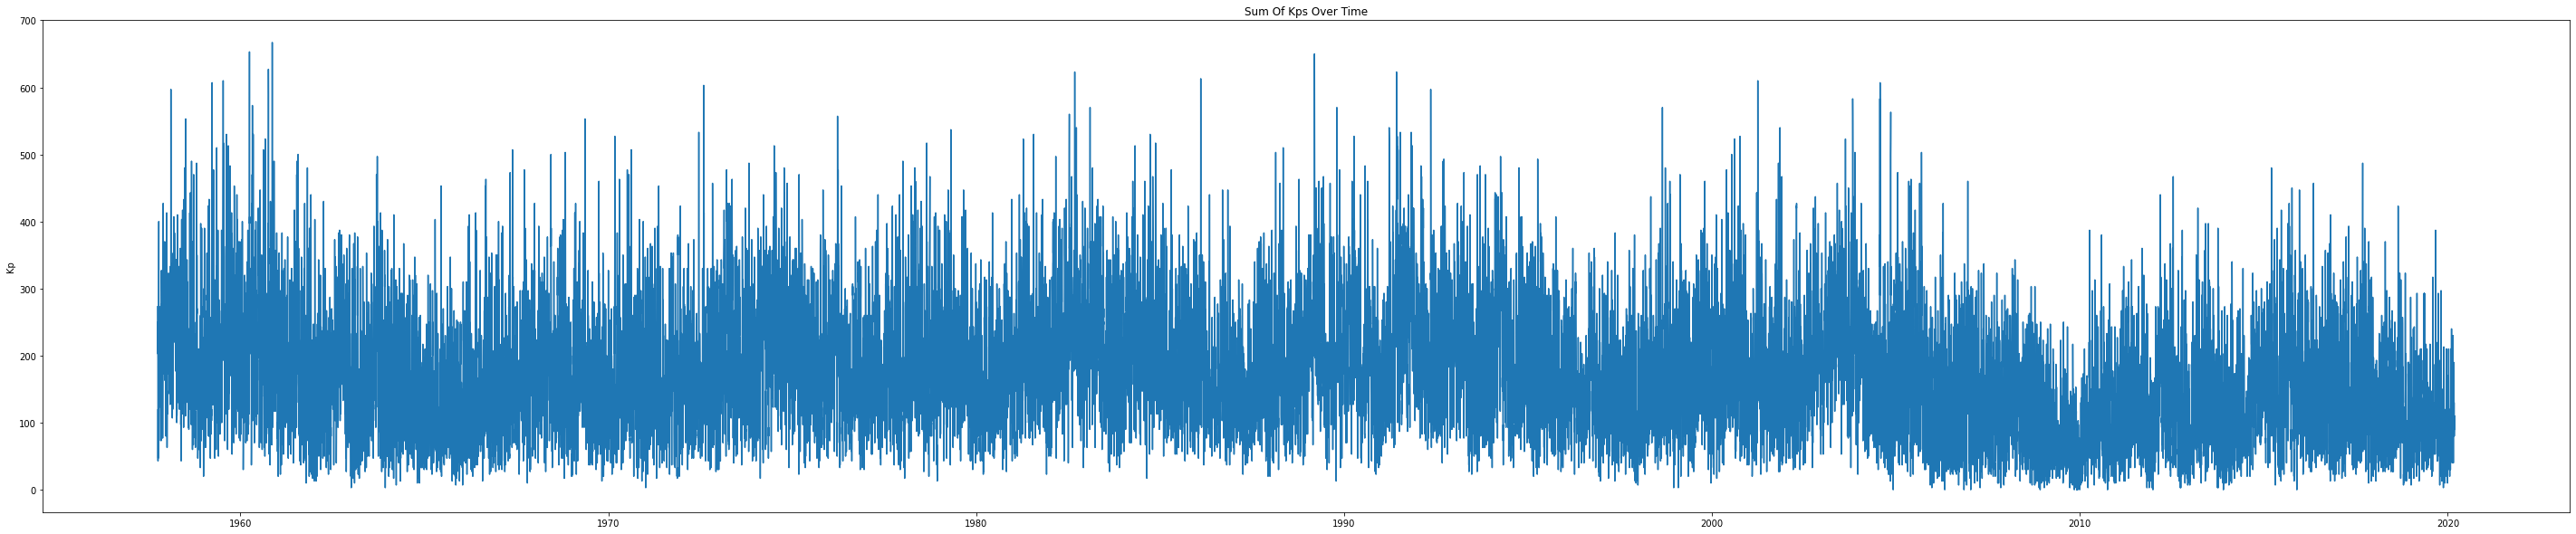

In [10]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 50
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.plot(df.index, df['SumOfKps'])
plt.title('Sum Of Kps Over Time')
plt.ylabel('Kp')
plt.show()

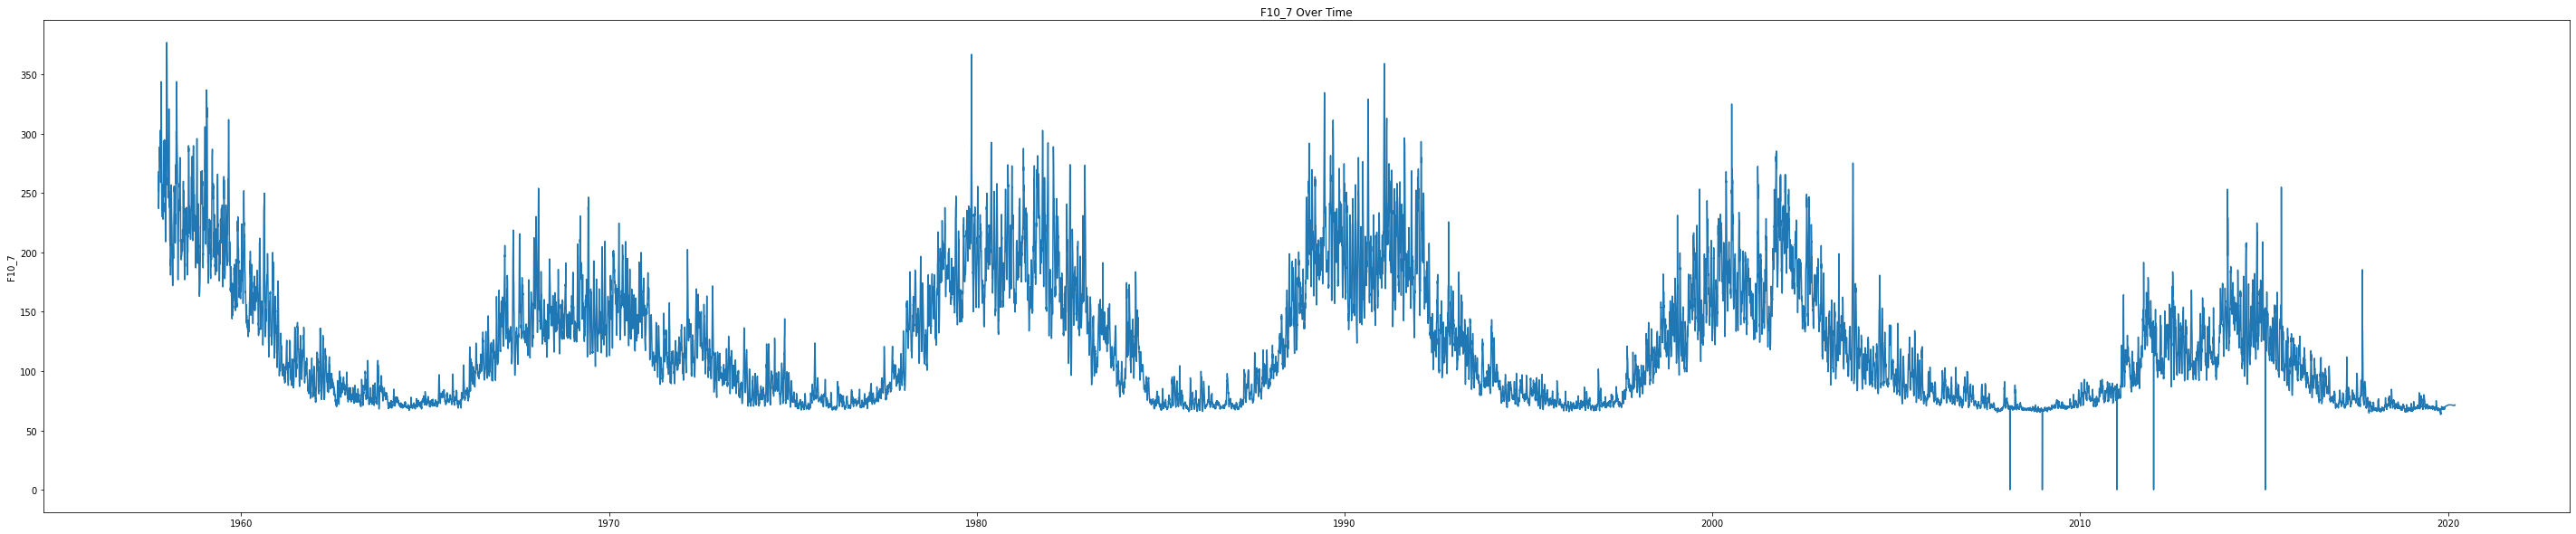

In [11]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 50
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.plot(df.index, df['F10_7'])
plt.title('F10_7 Over Time')
plt.ylabel('F10_7')
plt.show()

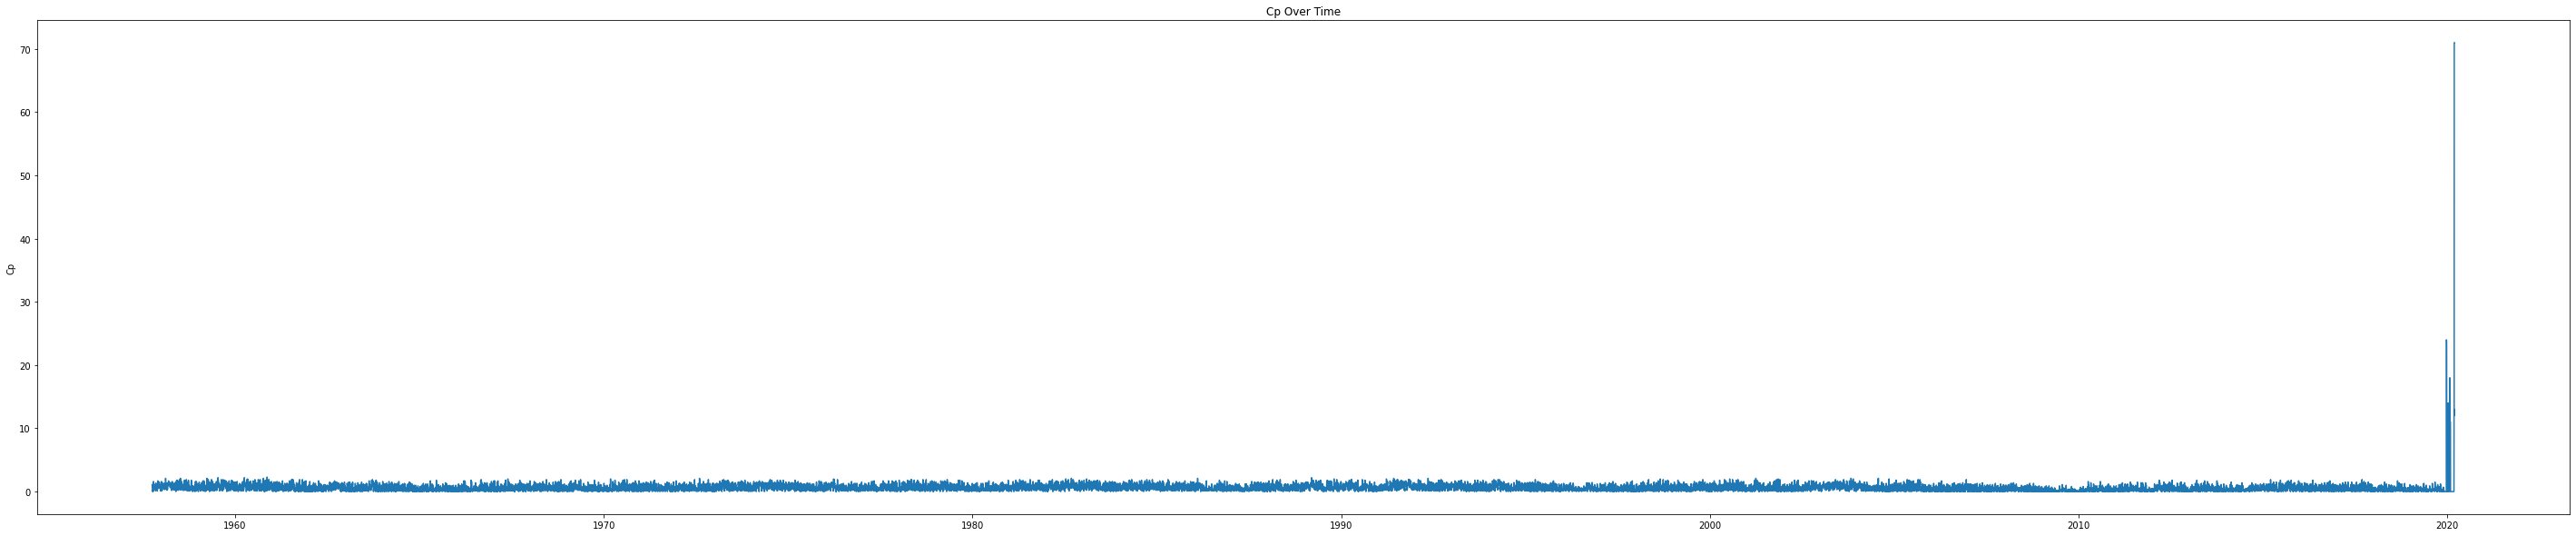

In [12]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 50
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.plot(df.index, df['PlanetaryDailyCharacterFigure'])
plt.title('Cp Over Time')
plt.ylabel('Cp')
plt.show()

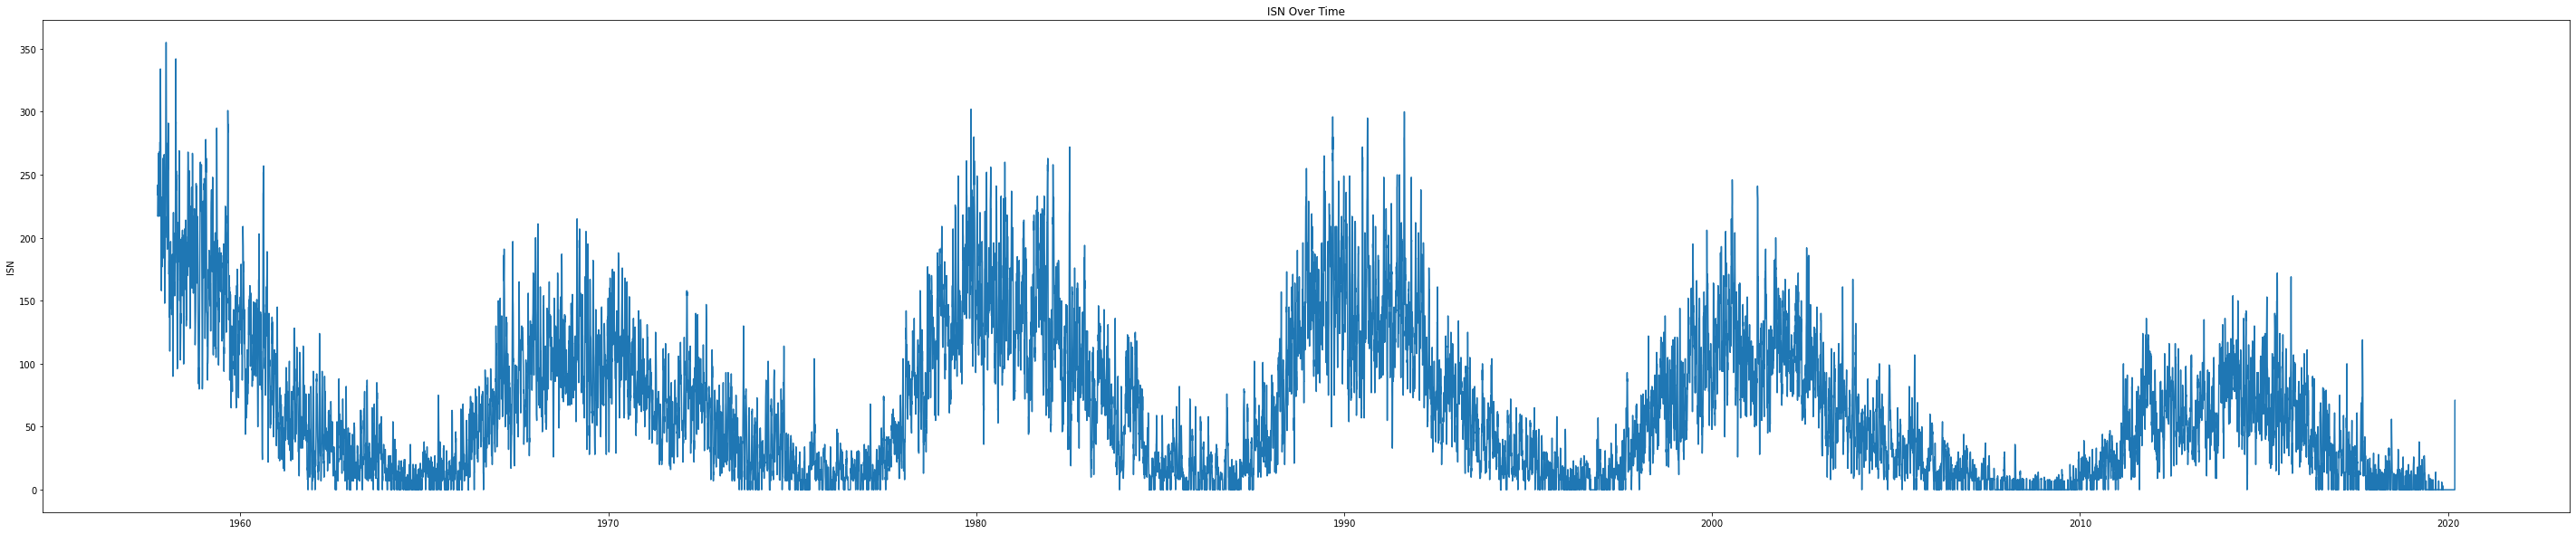

In [13]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 50
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.plot(df.index, df['InternationalSunspotNumber'])
plt.title('ISN Over Time')
plt.ylabel('ISN')
plt.show()

# Random Forest Regression

In [14]:
dfSpaceWeather.dropna()
x = dfSpaceWeather.iloc[:,33:34].values
y = dfSpaceWeather.iloc[:, 13].values
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(x,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [15]:
X_grid = np.arange(min(x), max(x), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(x,y,color = 'blue')
plt.plot(X_grid, regressor.predict(X_grid), color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('SumOfKps')
plt.ylabel('AverageTemp')
plt.show()

ValueError: Could not convert object to NumPy datetime

# Time Series

In [16]:
df = dfSpaceWeather.rename(columns={'Date': 'ds', 'F10_7': 'y'})
df

,Year,Month,Day,BartelsSolarRotationNumber,NumberofDaywithintheBartels,Kp_0000_0300,Kp_0300_0600,Kp_0600_0900,Kp_0900_1200,Kp_1200_1500,...,CpConversion,InternationalSunspotNumber,y,FluxQualifier,Centered81_dayArithmeticAverageofF10_7,Last81DayArithmeticAverageofF10_7,ObservedValueOfF10_7,Centered81DayArithmeticAverageOfF10_7,Last81DayArithmeticAverageOfF10_7,ds
0,1957,10,1,1700,19,43,40,30,20,37,...,5.0,236.0,268.0,0.0,265.2,230.6,269.3,266.6,230.9,1957-10-01
1,1957,10,2,1700,20,37,37,17,17,27,...,3.0,234.0,252.0,0.0,266.0,231.4,253.3,267.4,231.7,1957-10-02
2,1957,10,3,1700,21,27,20,13,33,37,...,5.0,242.0,265.0,0.0,266.7,232.3,266.3,268.1,232.7,1957-10-03
3,1957,10,4,1700,22,30,30,23,27,23,...,3.0,217.0,237.0,0.0,267.4,232.9,238.2,268.8,233.3,1957-10-04
4,1957,10,5,1700,23,30,30,17,23,20,...,3.0,219.0,245.0,0.0,267.8,233.5,246.2,269.3,233.9,1957-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22803,2020,3,7,2545,7,10,20,20,20,20,...,70.0,0.0,71.1,71.5,71.1,72.1,73.5,NaN,NaN,2020-03-07
22804,2020,3,8,2545,8,10,20,20,10,10,...,70.0,0.0,71.1,71.5,71.0,72.0,73.5,NaN,NaN,2020-03-08
22805,2020,3,9,2545,9,10,20,20,10,10,...,71.0,0.0,71.0,71.5,72.0,72.0,73.5,NaN,NaN,2020-03-09
22806,2020,3,10,2545,10,20,10,20,10,10,...,0.0,71.0,71.5,72.0,71.9,73.5,NaN,NaN,NaN,2020-03-10


In [17]:
model = fbprophet.Prophet(changepoint_prior_scale=0.15)
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'F10_7 Predictions')

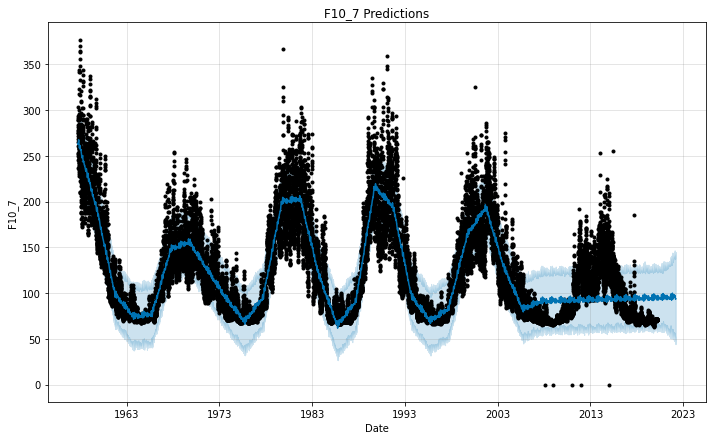

In [18]:
df_forecast = model.make_future_dataframe(periods=365 * 2, freq='D')
df_forecast = model.predict(df_forecast)

model.plot(df_forecast, xlabel = 'Date', ylabel = 'F10_7')
plt.title('F10_7 Predictions')

In [19]:
model.changepoints[:10]

730    1959-10-01
1460   1961-09-30
2189   1963-09-29
2919   1965-09-28
3649   1967-09-28
4379   1969-09-27
5109   1971-09-27
5838   1973-09-25
6568   1975-09-25
7298   1977-09-24
Name: ds, dtype: datetime64[ns]

In [20]:
dfKps = dfSpaceWeather.rename(columns={'Date': 'ds', 'SumOfKps': 'y'})
dfKps

,Year,Month,Day,BartelsSolarRotationNumber,NumberofDaywithintheBartels,Kp_0000_0300,Kp_0300_0600,Kp_0600_0900,Kp_0900_1200,Kp_1200_1500,...,CpConversion,InternationalSunspotNumber,F10_7,FluxQualifier,Centered81_dayArithmeticAverageofF10_7,Last81DayArithmeticAverageofF10_7,ObservedValueOfF10_7,Centered81DayArithmeticAverageOfF10_7,Last81DayArithmeticAverageOfF10_7,ds
0,1957,10,1,1700,19,43,40,30,20,37,...,5.0,236.0,268.0,0.0,265.2,230.6,269.3,266.6,230.9,1957-10-01
1,1957,10,2,1700,20,37,37,17,17,27,...,3.0,234.0,252.0,0.0,266.0,231.4,253.3,267.4,231.7,1957-10-02
2,1957,10,3,1700,21,27,20,13,33,37,...,5.0,242.0,265.0,0.0,266.7,232.3,266.3,268.1,232.7,1957-10-03
3,1957,10,4,1700,22,30,30,23,27,23,...,3.0,217.0,237.0,0.0,267.4,232.9,238.2,268.8,233.3,1957-10-04
4,1957,10,5,1700,23,30,30,17,23,20,...,3.0,219.0,245.0,0.0,267.8,233.5,246.2,269.3,233.9,1957-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22803,2020,3,7,2545,7,10,20,20,20,20,...,70.0,0.0,71.1,71.5,71.1,72.1,73.5,NaN,NaN,2020-03-07
22804,2020,3,8,2545,8,10,20,20,10,10,...,70.0,0.0,71.1,71.5,71.0,72.0,73.5,NaN,NaN,2020-03-08
22805,2020,3,9,2545,9,10,20,20,10,10,...,71.0,0.0,71.0,71.5,72.0,72.0,73.5,NaN,NaN,2020-03-09
22806,2020,3,10,2545,10,20,10,20,10,10,...,0.0,71.0,71.5,72.0,71.9,73.5,NaN,NaN,NaN,2020-03-10


In [21]:
model2 = fbprophet.Prophet(changepoint_prior_scale=0.15)
model2.fit(dfKps)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Kp Predictions')

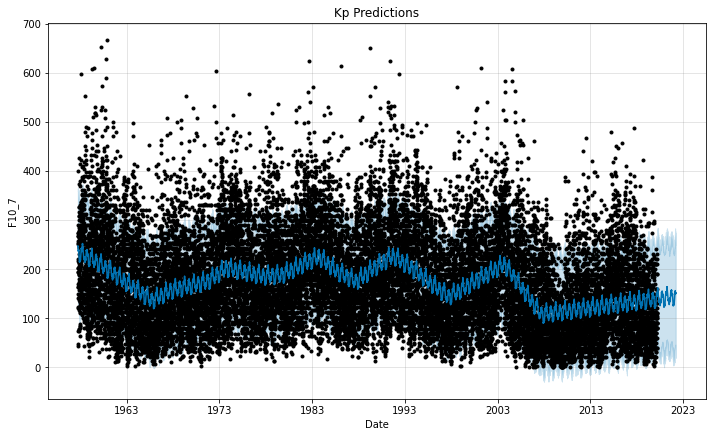

In [22]:
df_forecast2 = model2.make_future_dataframe(periods=365 * 2, freq='D')
df_forecast2 = model2.predict(df_forecast2)

model2.plot(df_forecast2, xlabel = 'Date', ylabel = 'F10_7')
plt.title('Kp Predictions')

In [23]:
dfFlux = dfSpaceWeather.rename(columns={'Date': 'ds', 'FluxQualifier': 'y'})
dfFlux

,Year,Month,Day,BartelsSolarRotationNumber,NumberofDaywithintheBartels,Kp_0000_0300,Kp_0300_0600,Kp_0600_0900,Kp_0900_1200,Kp_1200_1500,...,CpConversion,InternationalSunspotNumber,F10_7,y,Centered81_dayArithmeticAverageofF10_7,Last81DayArithmeticAverageofF10_7,ObservedValueOfF10_7,Centered81DayArithmeticAverageOfF10_7,Last81DayArithmeticAverageOfF10_7,ds
0,1957,10,1,1700,19,43,40,30,20,37,...,5.0,236.0,268.0,0.0,265.2,230.6,269.3,266.6,230.9,1957-10-01
1,1957,10,2,1700,20,37,37,17,17,27,...,3.0,234.0,252.0,0.0,266.0,231.4,253.3,267.4,231.7,1957-10-02
2,1957,10,3,1700,21,27,20,13,33,37,...,5.0,242.0,265.0,0.0,266.7,232.3,266.3,268.1,232.7,1957-10-03
3,1957,10,4,1700,22,30,30,23,27,23,...,3.0,217.0,237.0,0.0,267.4,232.9,238.2,268.8,233.3,1957-10-04
4,1957,10,5,1700,23,30,30,17,23,20,...,3.0,219.0,245.0,0.0,267.8,233.5,246.2,269.3,233.9,1957-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22803,2020,3,7,2545,7,10,20,20,20,20,...,70.0,0.0,71.1,71.5,71.1,72.1,73.5,NaN,NaN,2020-03-07
22804,2020,3,8,2545,8,10,20,20,10,10,...,70.0,0.0,71.1,71.5,71.0,72.0,73.5,NaN,NaN,2020-03-08
22805,2020,3,9,2545,9,10,20,20,10,10,...,71.0,0.0,71.0,71.5,72.0,72.0,73.5,NaN,NaN,2020-03-09
22806,2020,3,10,2545,10,20,10,20,10,10,...,0.0,71.0,71.5,72.0,71.9,73.5,NaN,NaN,NaN,2020-03-10


In [24]:
model3 = fbprophet.Prophet(changepoint_prior_scale=0.05)
model3.fit(dfFlux)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Flux Qualifier Predictions')

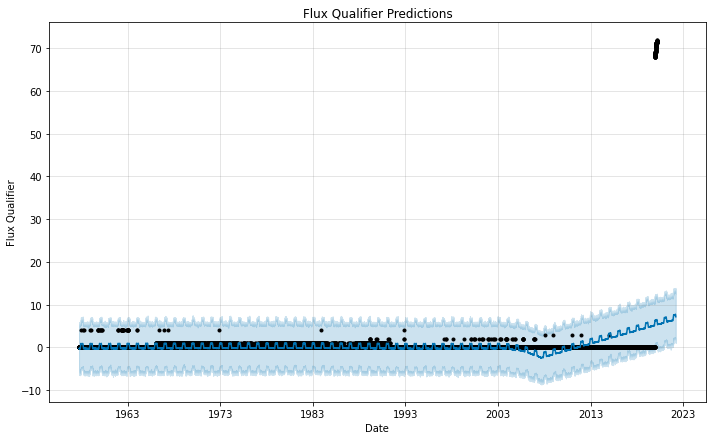

In [25]:
df_forecast3 = model3.make_future_dataframe(periods=365 * 2, freq='D')
df_forecast3 = model3.predict(df_forecast3)

model3.plot(df_forecast3, xlabel = 'Date', ylabel = 'Flux Qualifier')
plt.title('Flux Qualifier Predictions')

In [26]:
dfISN = dfSpaceWeather.rename(columns={'Date': 'ds', 'InternationalSunspotNumber': 'y'})
dfISN

,Year,Month,Day,BartelsSolarRotationNumber,NumberofDaywithintheBartels,Kp_0000_0300,Kp_0300_0600,Kp_0600_0900,Kp_0900_1200,Kp_1200_1500,...,CpConversion,y,F10_7,FluxQualifier,Centered81_dayArithmeticAverageofF10_7,Last81DayArithmeticAverageofF10_7,ObservedValueOfF10_7,Centered81DayArithmeticAverageOfF10_7,Last81DayArithmeticAverageOfF10_7,ds
0,1957,10,1,1700,19,43,40,30,20,37,...,5.0,236.0,268.0,0.0,265.2,230.6,269.3,266.6,230.9,1957-10-01
1,1957,10,2,1700,20,37,37,17,17,27,...,3.0,234.0,252.0,0.0,266.0,231.4,253.3,267.4,231.7,1957-10-02
2,1957,10,3,1700,21,27,20,13,33,37,...,5.0,242.0,265.0,0.0,266.7,232.3,266.3,268.1,232.7,1957-10-03
3,1957,10,4,1700,22,30,30,23,27,23,...,3.0,217.0,237.0,0.0,267.4,232.9,238.2,268.8,233.3,1957-10-04
4,1957,10,5,1700,23,30,30,17,23,20,...,3.0,219.0,245.0,0.0,267.8,233.5,246.2,269.3,233.9,1957-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22803,2020,3,7,2545,7,10,20,20,20,20,...,70.0,0.0,71.1,71.5,71.1,72.1,73.5,NaN,NaN,2020-03-07
22804,2020,3,8,2545,8,10,20,20,10,10,...,70.0,0.0,71.1,71.5,71.0,72.0,73.5,NaN,NaN,2020-03-08
22805,2020,3,9,2545,9,10,20,20,10,10,...,71.0,0.0,71.0,71.5,72.0,72.0,73.5,NaN,NaN,2020-03-09
22806,2020,3,10,2545,10,20,10,20,10,10,...,0.0,71.0,71.5,72.0,71.9,73.5,NaN,NaN,NaN,2020-03-10


In [27]:
model4 = fbprophet.Prophet(changepoint_prior_scale=0.15)
model4.fit(dfISN)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'ISN Predictions')

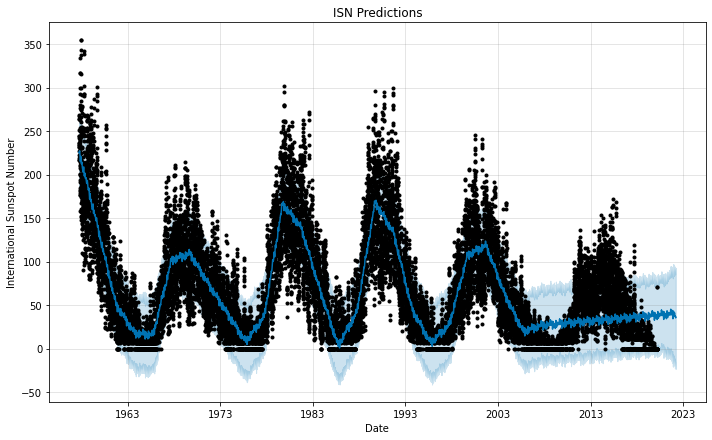

In [28]:
df_forecast4 = model4.make_future_dataframe(periods=365 * 2, freq='D')
df_forecast4 = model4.predict(df_forecast4)

model4.plot(df_forecast4, xlabel = 'Date', ylabel = 'International Sunspot Number')
plt.title('ISN Predictions')

### Based on the time series graphs above, i am going to start by prediction F10.7 because it seems to have the best "pattern". I would also like to see if i can try and predict SumOfKps because it seems to be the one with the worst pattern and i'm curious to see how difficult it would be to predict. 

In [29]:
dfSpaceWeather.columns

Index(['Year', 'Month', 'Day', 'BartelsSolarRotationNumber',
       'NumberofDaywithintheBartels', 'Kp_0000_0300', 'Kp_0300_0600',
       'Kp_0600_0900', 'Kp_0900_1200', 'Kp_1200_1500', 'Kp_1500_1800',
       'Kp_1800_2100', 'Kp_2100_0000', 'SumOfKps',
       'PlanetaryEquivalentAmplitude_0000_0300',
       'PlanetaryEquivalentAmplitude_0300_0600',
       'PlanetaryEquivalentAmplitude_0600_0900',
       'PlanetaryEquivalentAmplitude_0900_1200',
       'PlanetaryEquivalentAmplitude_1200_1500',
       'PlanetaryEquivalentAmplitude_1500_1800',
       'PlanetaryEquivalentAmplitude_1800_2100',
       'PlanetaryEquivalentAmplitude_2100_0000', 'ArithmeticAverageof8Ap',
       'PlanetaryDailyCharacterFigure', 'CpConversion',
       'InternationalSunspotNumber', 'F10_7', 'FluxQualifier',
       'Centered81_dayArithmeticAverageofF10_7',
       'Last81DayArithmeticAverageofF10_7', 'ObservedValueOfF10_7',
       'Centered81DayArithmeticAverageOfF10_7',
       'Last81DayArithmeticAverageOfF10_7', '

# F10.7 Prediction

In [30]:
dfF107Pred = dfSpaceWeather.set_index('Date')
dfF107Pred = dfF107Pred.drop(columns=["Year","Month","Day"])
dfF107Pred

,BartelsSolarRotationNumber,NumberofDaywithintheBartels,Kp_0000_0300,Kp_0300_0600,Kp_0600_0900,Kp_0900_1200,Kp_1200_1500,Kp_1500_1800,Kp_1800_2100,Kp_2100_0000,...,PlanetaryDailyCharacterFigure,CpConversion,InternationalSunspotNumber,F10_7,FluxQualifier,Centered81_dayArithmeticAverageofF10_7,Last81DayArithmeticAverageofF10_7,ObservedValueOfF10_7,Centered81DayArithmeticAverageOfF10_7,Last81DayArithmeticAverageOfF10_7
Date,,,,,,,,,,,,,,,,,,,,,
1957-10-01,1700,19,43,40,30,20,37,23,43,37,...,1.1,5.0,236.0,268.0,0.0,265.2,230.6,269.3,266.6,230.9
1957-10-02,1700,20,37,37,17,17,27,23,17,30,...,0.7,3.0,234.0,252.0,0.0,266.0,231.4,253.3,267.4,231.7
1957-10-03,1700,21,27,20,13,33,37,47,43,30,...,1.0,5.0,242.0,265.0,0.0,266.7,232.3,266.3,268.1,232.7
1957-10-04,1700,22,30,30,23,27,23,27,30,27,...,0.7,3.0,217.0,237.0,0.0,267.4,232.9,238.2,268.8,233.3
1957-10-05,1700,23,30,30,17,23,20,27,27,20,...,0.6,3.0,219.0,245.0,0.0,267.8,233.5,246.2,269.3,233.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-07,2545,7,10,20,20,20,20,10,0,0,...,0.0,70.0,0.0,71.1,71.5,71.1,72.1,73.5,NaN,NaN
2020-03-08,2545,8,10,20,20,10,10,10,20,10,...,13.0,70.0,0.0,71.1,71.5,71.0,72.0,73.5,NaN,NaN
2020-03-09,2545,9,10,20,20,10,10,10,20,10,...,12.0,71.0,0.0,71.0,71.5,72.0,72.0,73.5,NaN,NaN


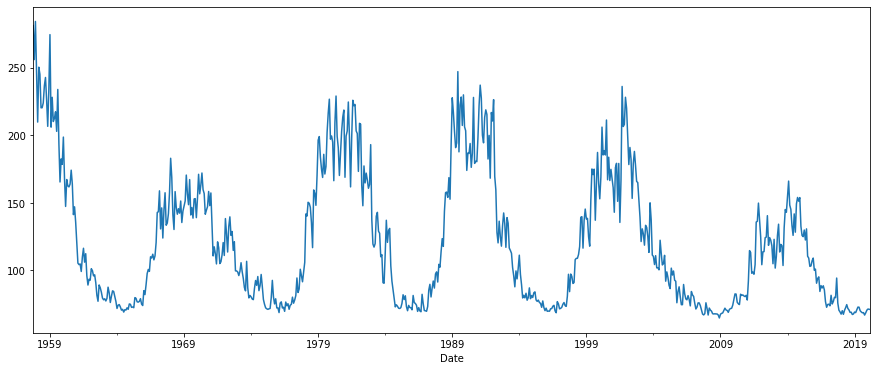

In [31]:
y = dfF107Pred['F10_7'].resample('MS').mean()
y.plot(figsize=(15,6))
plt.show()

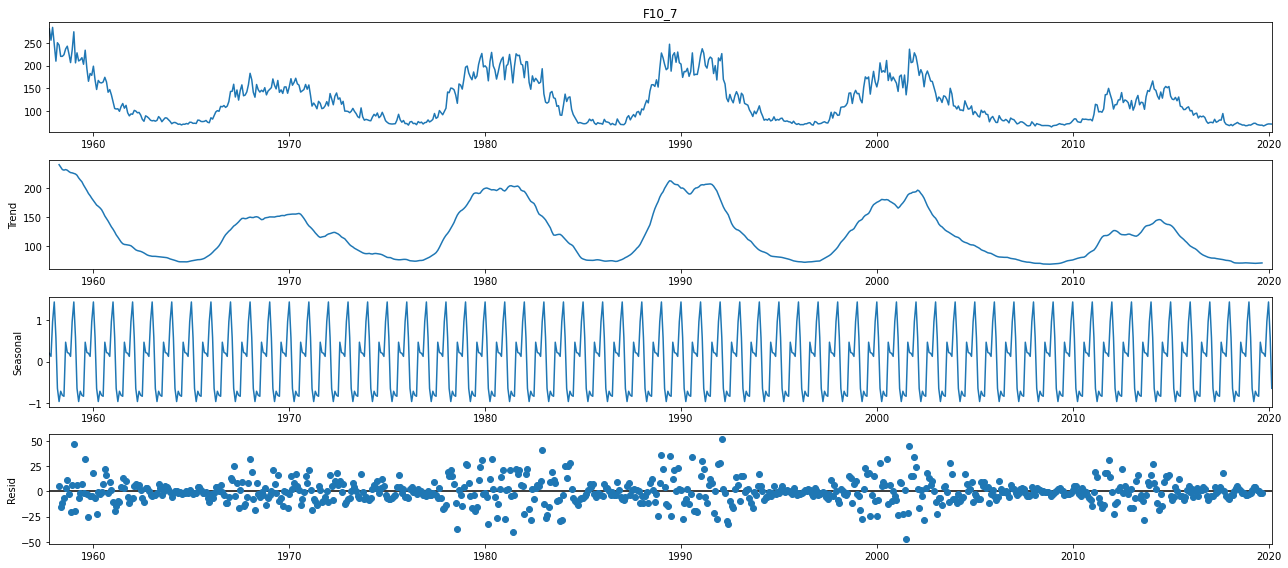

In [32]:
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [70]:
# Check to see if the data is stationary
result = adfuller(dfF107Pred['F10_7'])

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.3048241979140105
p-value: 0.00043574473076614856
Critical Values:
	1%: -3.430637347876771
	5%: -2.861666998510783
	10%: -2.566837597689731


### There is clearly a trend in the data and the data appears to be stationary. 

c:\users\heath\.conda\envs\opencv\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Autocorrelation Function')

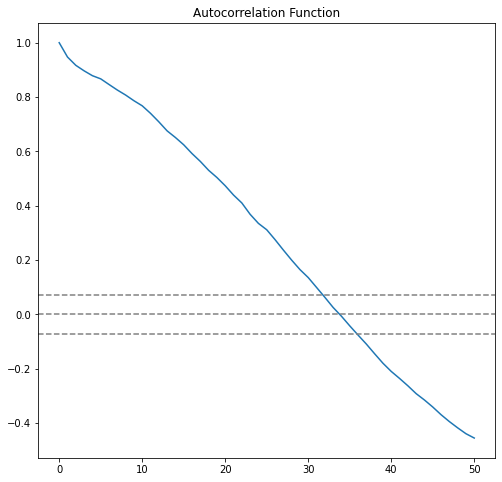

In [33]:
# ACF and PACF plots 
lag_acf = acf(y, nlags=50)
lag_pacf = pacf(y, nlags=50, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

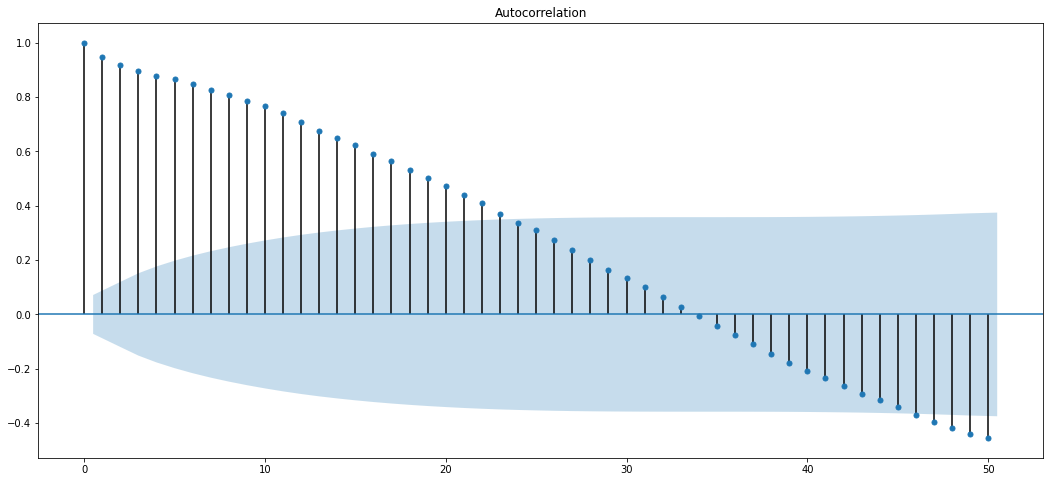

In [34]:
plot_acf(y, lags=50)
plt.show()

### If i'm interpreting the above plots correctly, F10.7 is positively correlated up to 30? 

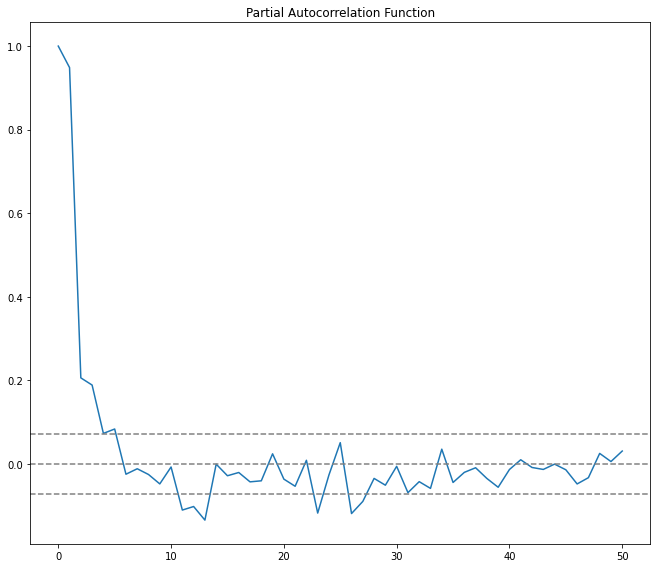

In [35]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

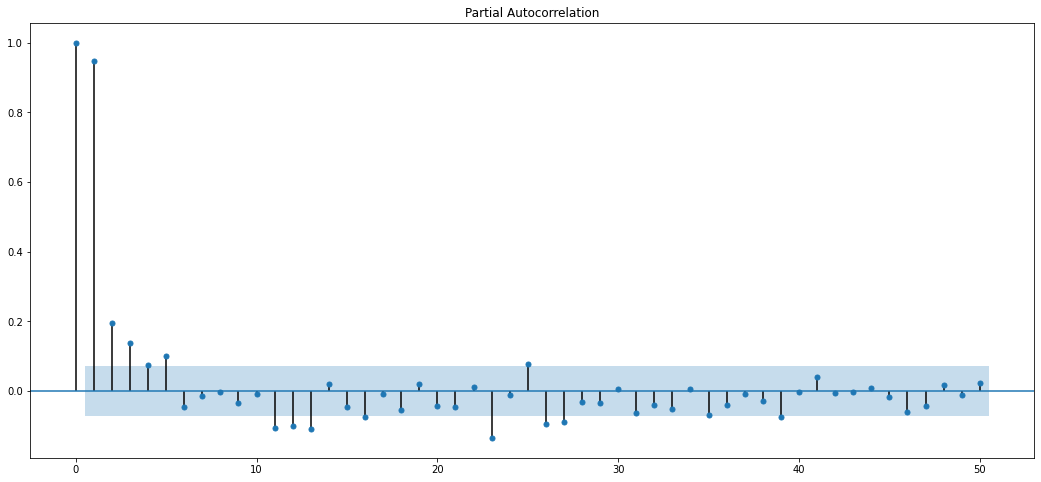

In [36]:
plot_pacf(y, lags=50)
plt.show()

### The above cell tells me that F10.7 has significant partial auto correlation at 2,4,11,12,13,23,26,27. I'm not seeing any pattern in the periods. 

## ARIMA Model

Text(0.5, 1.0, 'RSS: 163931.1027')

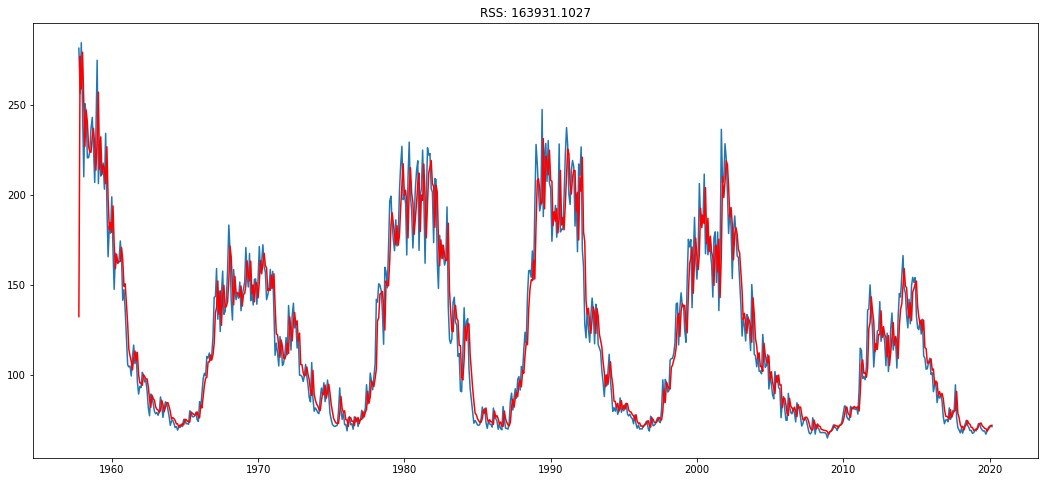

In [98]:
modelArima = ARIMA(y, order=(3,0,2))
results_AR_F107 = modelArima.fit(disp=-1)
plt.plot(y)
plt.plot(results_AR_F107.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_F107.fittedvalues-y)**2))

In [99]:
print(results_AR_F107.summary().tables[1])

                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         132.2572     27.885      4.743      0.000      77.603     186.911
ar.L1.F10_7     0.6679      0.285      2.345      0.019       0.110       1.226
ar.L2.F10_7     0.3528      0.376      0.938      0.348      -0.385       1.090
ar.L3.F10_7    -0.0332      0.123     -0.270      0.787      -0.274       0.208
ma.L1.F10_7     0.0382      0.281      0.136      0.892      -0.513       0.590
ma.L2.F10_7    -0.2730      0.179     -1.521      0.128      -0.625       0.079


c:\users\heath\.conda\envs\opencv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


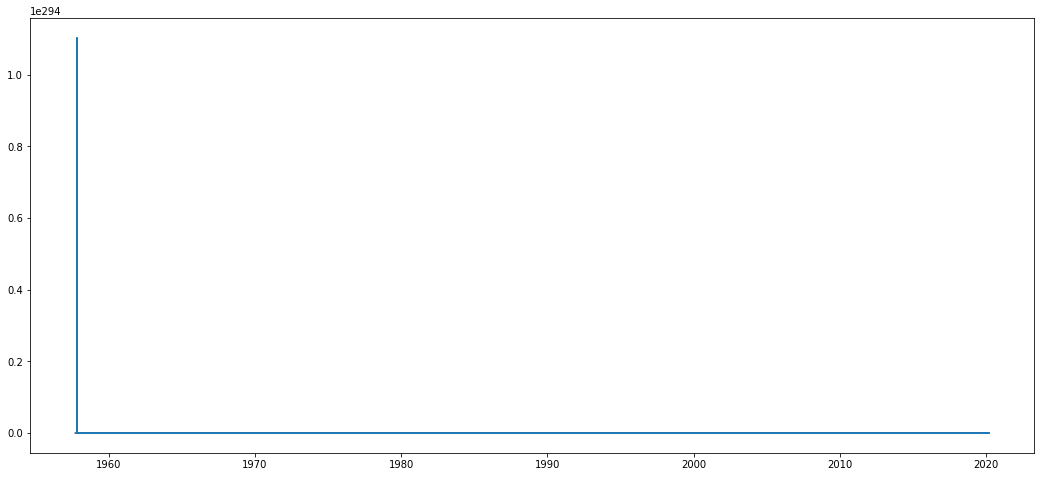

In [100]:
predictions_ARIMA_diff = pd.Series(results_AR_F107.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(dfF107Pred['F10_7'].iloc[0], index=dfF107Pred.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(dfF107Pred)
plt.plot(predictions_ARIMA)

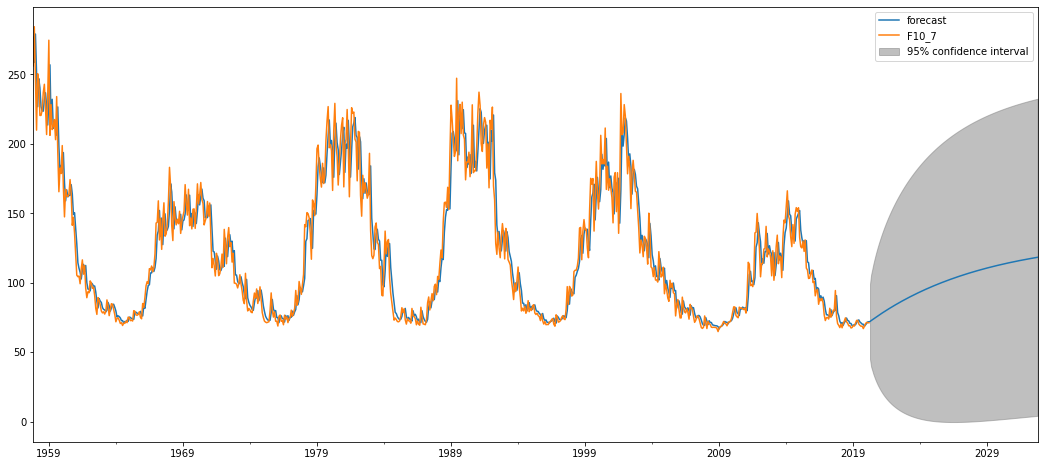

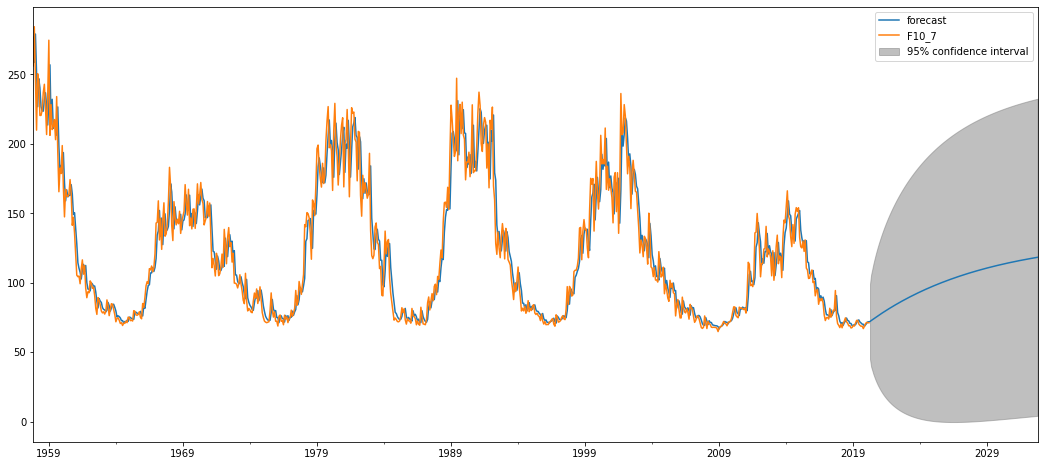

In [101]:
results_AR_F107.plot_predict(1,900)

## SARIMAX Model

In [40]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3365      0.057      5.914      0.000       0.225       0.448
ma.L1         -0.6815      0.046    -14.959      0.000      -0.771      -0.592
ar.S.L12      -0.4411      0.026    -16.989      0.000      -0.492      -0.390
sigma2       278.2866      9.945     27.983      0.000     258.795     297.778


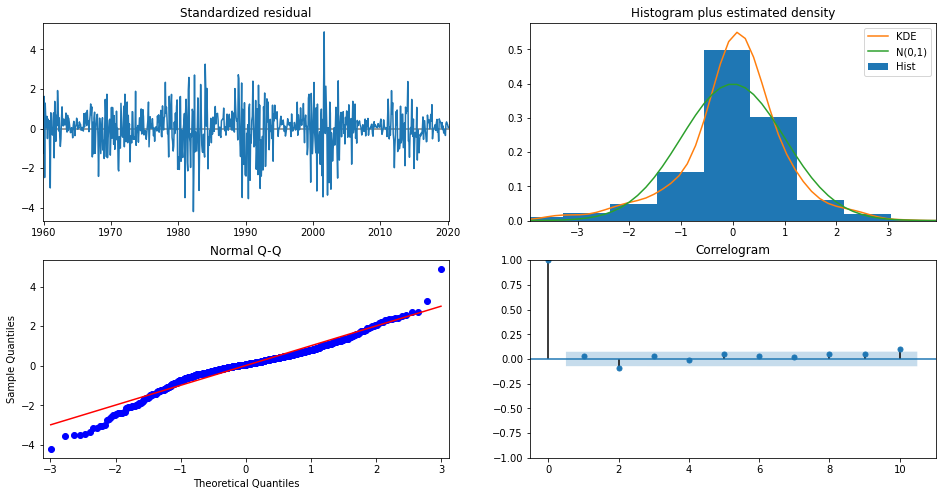

In [41]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

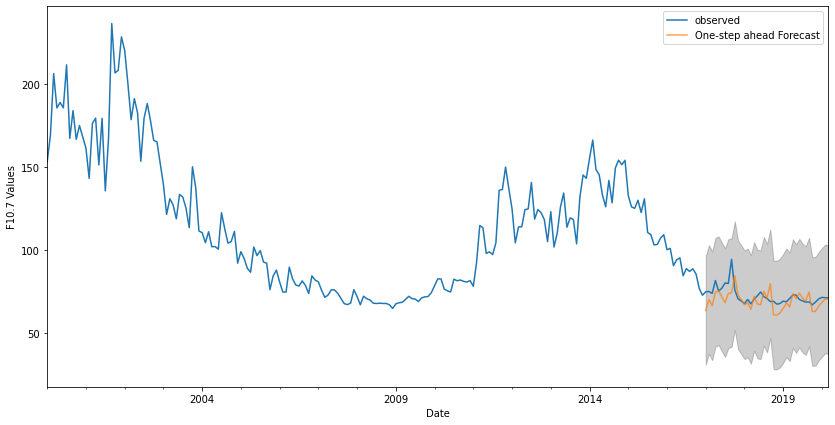

In [42]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('F10.7 Values')
plt.legend()
plt.show()

### Our predicted values seem to somewhat align with the actual values, but are a little off. 

In [43]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 38.39


### The mean squared error suggests that our predictions are closer than i thought by looking at the graph. 

In [44]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 6.2


### The RMSE tells me that the model was able to forecast the F10.7 value within 6.2 which looks pretty good to me. 

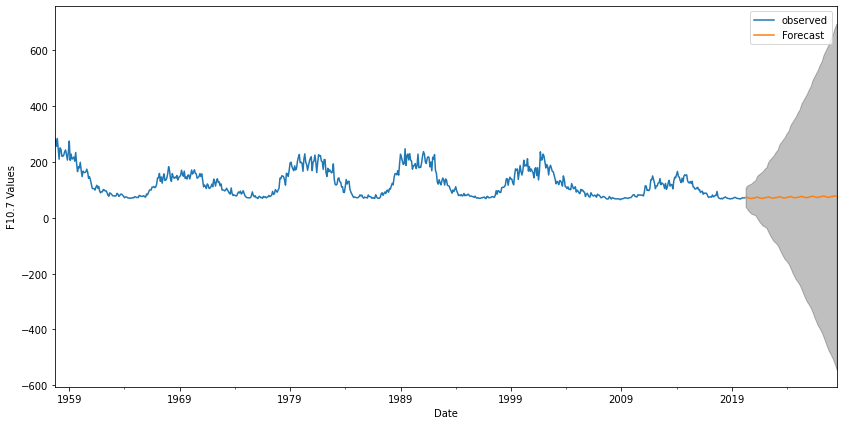

In [45]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('F10.7 Values')
plt.legend()
plt.show()

## SES Model

In [46]:
ses_model = SimpleExpSmoothing(y)
ses_results1 = ses_model.fit(smoothing_level=0.2, optimized=False)
fcast1 = ses_results1.forecast(3).rename(r'$\alpha=0.2$')
print(ses_results1.summary().tables[1])

ses_results2 = ses_model.fit(smoothing_level=0.6, optimized =False)
fcast2 = ses_results2.forecast(3).rename(r'$\alpha=0.6$')
print(ses_results2.summary().tables[1])

                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2000000                alpha                False
initial_level              281.22581                  l.0                False
------------------------------------------------------------------------------
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6000000                alpha                False
initial_level              281.22581                  l.0                False
------------------------------------------------------------------------------


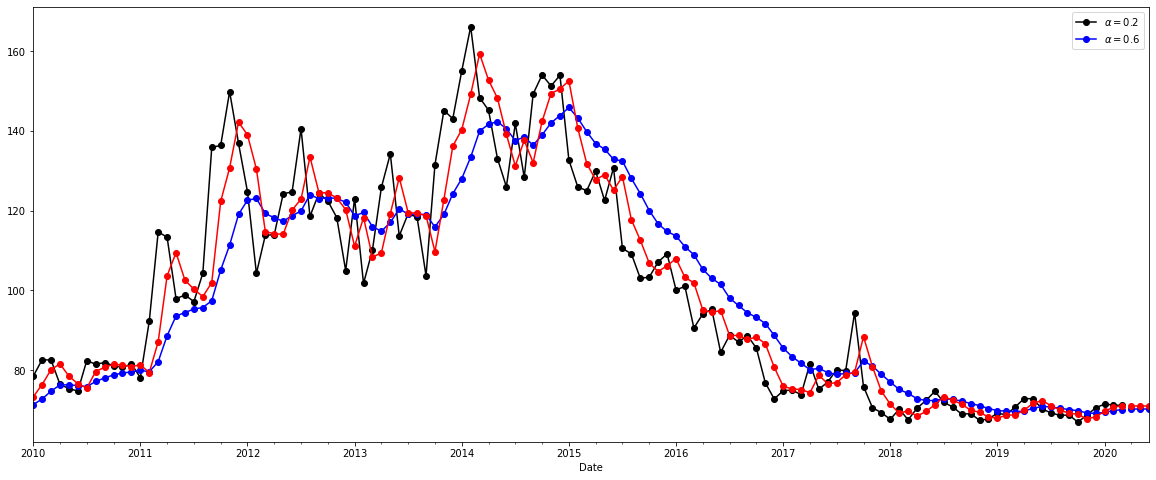

In [47]:
ax = y['2010':].plot(marker='o', color='black', figsize=(20,8))
#ax = y.plot(marker='o', color='black', figsize=(20,8))
fcast1['2010':].plot(marker='o', ax=ax, color='blue', legend=True)
ses_results1.fittedvalues['2010':].plot(marker='o', ax=ax, color='blue')
fcast2['2010':].plot(marker='o',ax=ax, color='red', legend=True)
ses_results2.fittedvalues['2010':].plot(marker='o', ax=ax, color='red')
plt.show()

### It looks like the smoothing value of .2 is the best fit. 

# SumOfKps prediction

In [48]:
dfKpPred = dfSpaceWeather.set_index('Date')
dfKpPred = dfKpPred.drop(columns=["Year","Month","Day"])
dfKpPred

,BartelsSolarRotationNumber,NumberofDaywithintheBartels,Kp_0000_0300,Kp_0300_0600,Kp_0600_0900,Kp_0900_1200,Kp_1200_1500,Kp_1500_1800,Kp_1800_2100,Kp_2100_0000,...,PlanetaryDailyCharacterFigure,CpConversion,InternationalSunspotNumber,F10_7,FluxQualifier,Centered81_dayArithmeticAverageofF10_7,Last81DayArithmeticAverageofF10_7,ObservedValueOfF10_7,Centered81DayArithmeticAverageOfF10_7,Last81DayArithmeticAverageOfF10_7
Date,,,,,,,,,,,,,,,,,,,,,
1957-10-01,1700,19,43,40,30,20,37,23,43,37,...,1.1,5.0,236.0,268.0,0.0,265.2,230.6,269.3,266.6,230.9
1957-10-02,1700,20,37,37,17,17,27,23,17,30,...,0.7,3.0,234.0,252.0,0.0,266.0,231.4,253.3,267.4,231.7
1957-10-03,1700,21,27,20,13,33,37,47,43,30,...,1.0,5.0,242.0,265.0,0.0,266.7,232.3,266.3,268.1,232.7
1957-10-04,1700,22,30,30,23,27,23,27,30,27,...,0.7,3.0,217.0,237.0,0.0,267.4,232.9,238.2,268.8,233.3
1957-10-05,1700,23,30,30,17,23,20,27,27,20,...,0.6,3.0,219.0,245.0,0.0,267.8,233.5,246.2,269.3,233.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-07,2545,7,10,20,20,20,20,10,0,0,...,0.0,70.0,0.0,71.1,71.5,71.1,72.1,73.5,NaN,NaN
2020-03-08,2545,8,10,20,20,10,10,10,20,10,...,13.0,70.0,0.0,71.1,71.5,71.0,72.0,73.5,NaN,NaN
2020-03-09,2545,9,10,20,20,10,10,10,20,10,...,12.0,71.0,0.0,71.0,71.5,72.0,72.0,73.5,NaN,NaN


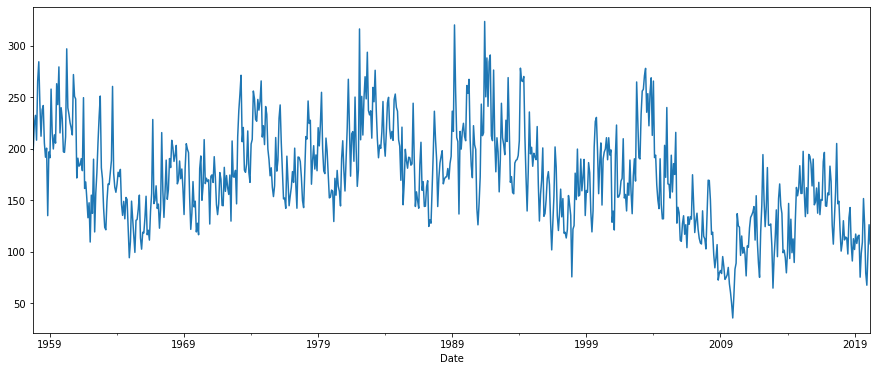

In [49]:
yKp = dfKpPred['SumOfKps'].resample('MS').mean()
yKp.plot(figsize=(15,6))
plt.show()

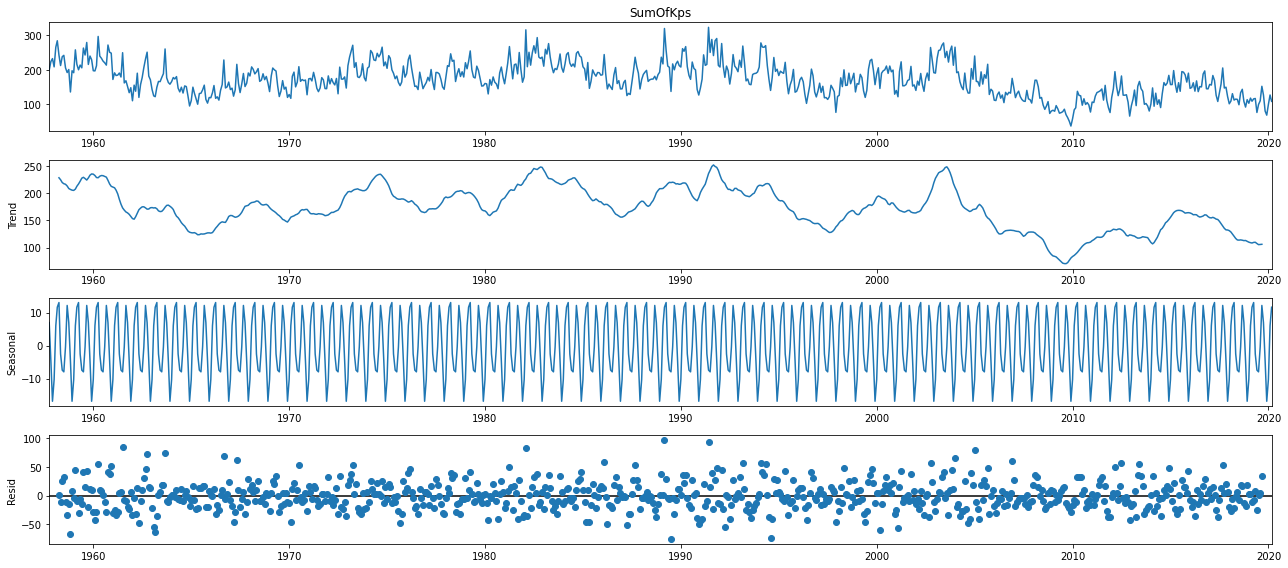

In [50]:
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(yKp, model='additive')
fig = decomposition.plot()
plt.show()

### The trend for SumOfKps is clearly not as strong as it was for F10.7

c:\users\heath\.conda\envs\opencv\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Autocorrelation Function')

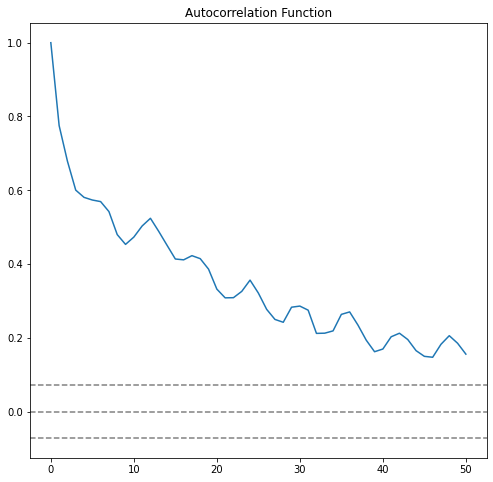

In [61]:
# ACF and PACF plots 
lag_acf = acf(yKp, nlags=50)
lag_pacf = pacf(yKp, nlags=50, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

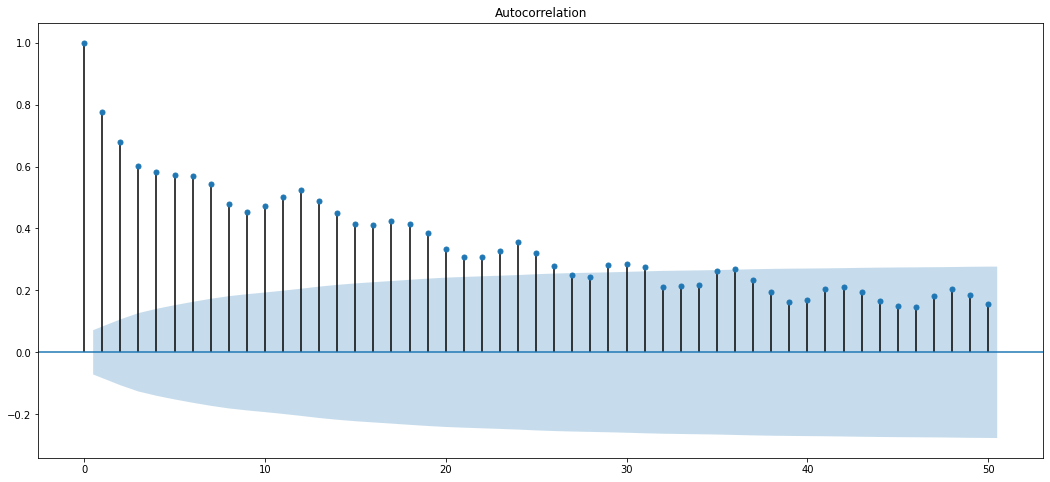

In [62]:
plot_acf(yKp, lags=50)
plt.show()

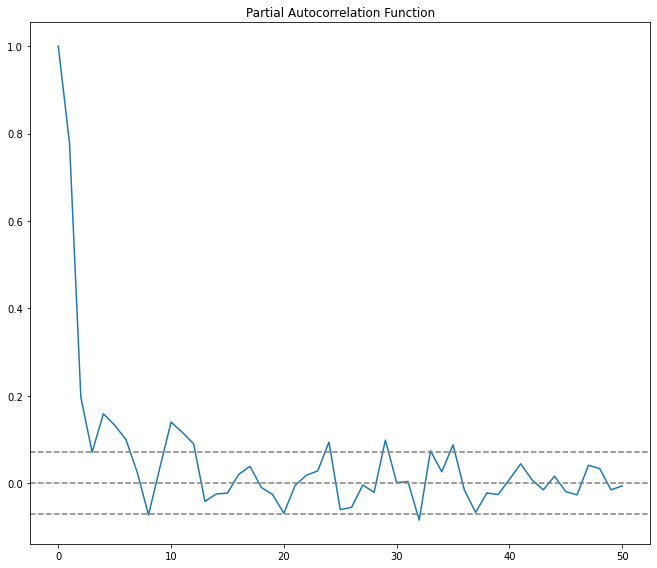

In [63]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

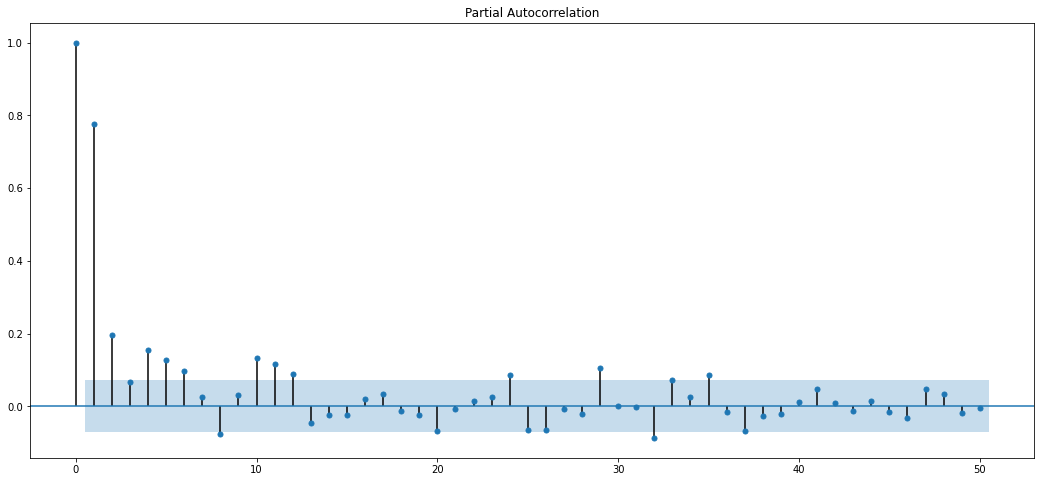

In [64]:
plot_pacf(yKp, lags=50)
plt.show()

## ARIMA Model

In [55]:
mod = sm.tsa.statespace.SARIMAX(yKp,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6544      0.029     22.388      0.000       0.597       0.712
ma.L1         -1.0000      4.735     -0.211      0.833     -10.281       8.281
ar.S.L12      -0.4794      0.032    -14.957      0.000      -0.542      -0.417
sigma2      1084.8011   5142.552      0.211      0.833   -8994.416    1.12e+04


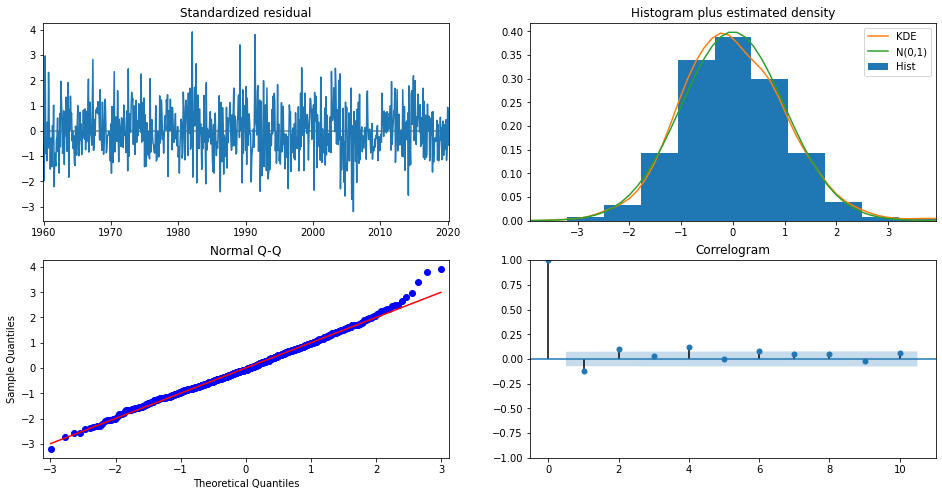

In [56]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

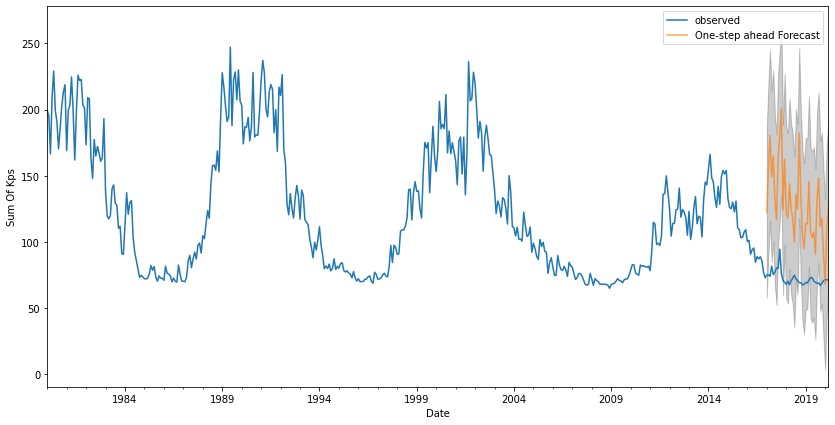

In [57]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['1980':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sum Of Kps')
plt.legend()
plt.show()

### Our predictions for Kp is not as good as it was for F10.7

In [58]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3967.62


### This Mean Squared Error is pretty high, and very high compared to our F10.7 MSE

In [59]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 62.99


### This RMSE tells me that my model was able to forecast the Kp Index within 62.99 of the real values. This seems like a decent number but pretty high compared to our F10.7 values. 

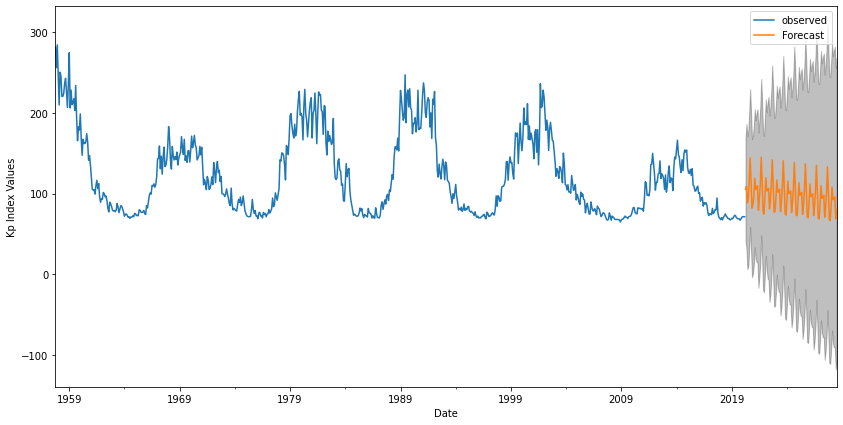

In [60]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Kp Index Values')
plt.legend()
plt.show()